#  어쩌다 키포인트 검출 제대로 입문하기

&nbsp;

<img src="https://drive.google.com/uc?export=view&id=1N-tsZ8dehPoN49nsuDUdMiHT1MsD7yg6" width=380px>

&nbsp;

## Pose Estimation ?


<img src = 'https://developer-blogs.nvidia.com/wp-content/uploads/2021/06/output-image-c.jpg' width=500>


- body part를 예측하는 분야로써 크게 2D, 3D로 나눌 수 있음
- 신체의 머리, 어깨, 관절 등의 keypoints를 예측하는 방법
- 일반적인 Object Detection에서는 Object에 해당하는 물체를 bounding box를 통해서 검출하였지만,Pose Estimation 분야에서는 사람의 행동, 자세를 중점으로 검출하기 때문에 사람의 행동을 보다 세밀하게 이해할수 있습니다.

> AI 경진대회에서 Pose Estimation 관련 대회가 나오고 있지만 쉽게 사용하는 방법에 관한 내용이 없어서 Pose Estimation을 더욱 쉽게 사용할 수 있는 MMPose 사용 방법에 초점을 두어 설명하겠습니다.


&nbsp;

## *MMpose* ?

<img src='https://raw.githubusercontent.com/open-mmlab/mmpose/master/resources/mmpose-logo.png'>


[MMPOSE 링크](https://github.com/open-mmlab/mmpose)
- Pytorch 기반으로 포즈 추정을 위한 오픈 소스
- 자세 추정은 animal, body, face, hand 등이 존재
- 2d, 3d 모두 지원하고 다양한 Pose model 사용이 쉬움

> MMPose는 다양한 모델 및 내부 Layer, Augmentation 등 모든 것이 config를 통해서 제어되는 방식입니다. MMPose에서 설정한 규칙을 이해한다면 MMPose가 제공하는 다양한 모델을 사용해보면서 결과를 도출할 수 있습니다.

&nbsp;

## mmpose 설치

- 첫 설치 후 런타임 자동 리셋 (리셋되면 해당 코드 다시 실행)

In [1]:
import os

if 'mmpose' not in os.listdir('./'):
  !pip install -U openmim
  !mim install mmcv-full

  !pip install mmdet==2.26.0

  !git clone https://github.com/open-mmlab/mmpose.git
  %cd mmpose

  !pip install -r requirements.txt
  !pip install -e .

  !pip install --upgrade numpy
  !pip install --upgrade --no-cache-dir gdown
  !pip install gradio

  os.kill(os.getpid(), 9)

else:
  !pip install --upgrade numpy

&nbsp;

## 사용할 패키지 불러오기

In [ ]:
import torch, torchvision
import mmpose
from mmcv import Config
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv
from glob import glob
import os
import os.path as osp
import tempfile
import warnings
import json
import random
from collections import OrderedDict, defaultdict
import json_tricks as json
import numpy as np
from mmcv import Config, deprecated_api_warning
from xtcocotools.cocoeval import COCOeval
from mmpose.core.post_processing import oks_nms, soft_oks_nms
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.base import Kpt2dSviewRgbImgTopDownDataset
from mmpose.apis import (inference_top_down_pose_model, init_pose_model, vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector
from google.colab.patches import cv2_imshow
import cv2
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import tkinter
import matplotlib
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm
from PIL import Image
import matplotlib.patches as patches
import random
import gradio as gr

&nbsp;

## 데이터 다운로드

<img src='https://production-media.paperswithcode.com/datasets/MPII-0000000344-d375bad7_ef0jlvO.jpg' >

- [MPII 데이터 셋](http://human-pose.mpi-inf.mpg.de/)
  -  데이터 세트에는 신체 관절에 주석이 달린 40,000명이 넘는 사람들이 포함된 약 25,000개의 이미지 가 포함 됨
  - 전반적으로 데이터 세트는 410개의 인간 활동을 다루고 각 이미지에는 활동 레이블이 제공 됨
  - 사용할 데이터는 random으로 선택한 train : 800장, val : 100 장, test : 100 장 (총 1000장만 사용)

In [ ]:
os.chdir('mmpose')
!gdown https://drive.google.com/uc?id=1J0tXSQXoZXgMDKf0s3AXUZBE1sT4j1mx
!unzip -qq "/content/mmpose/data.zip"

Downloading...
From: https://drive.google.com/uc?id=1J0tXSQXoZXgMDKf0s3AXUZBE1sT4j1mx
To: /content/mmpose/data.zip
100% 855M/855M [00:10<00:00, 84.3MB/s]


&nbsp;

## 데이터 시각화

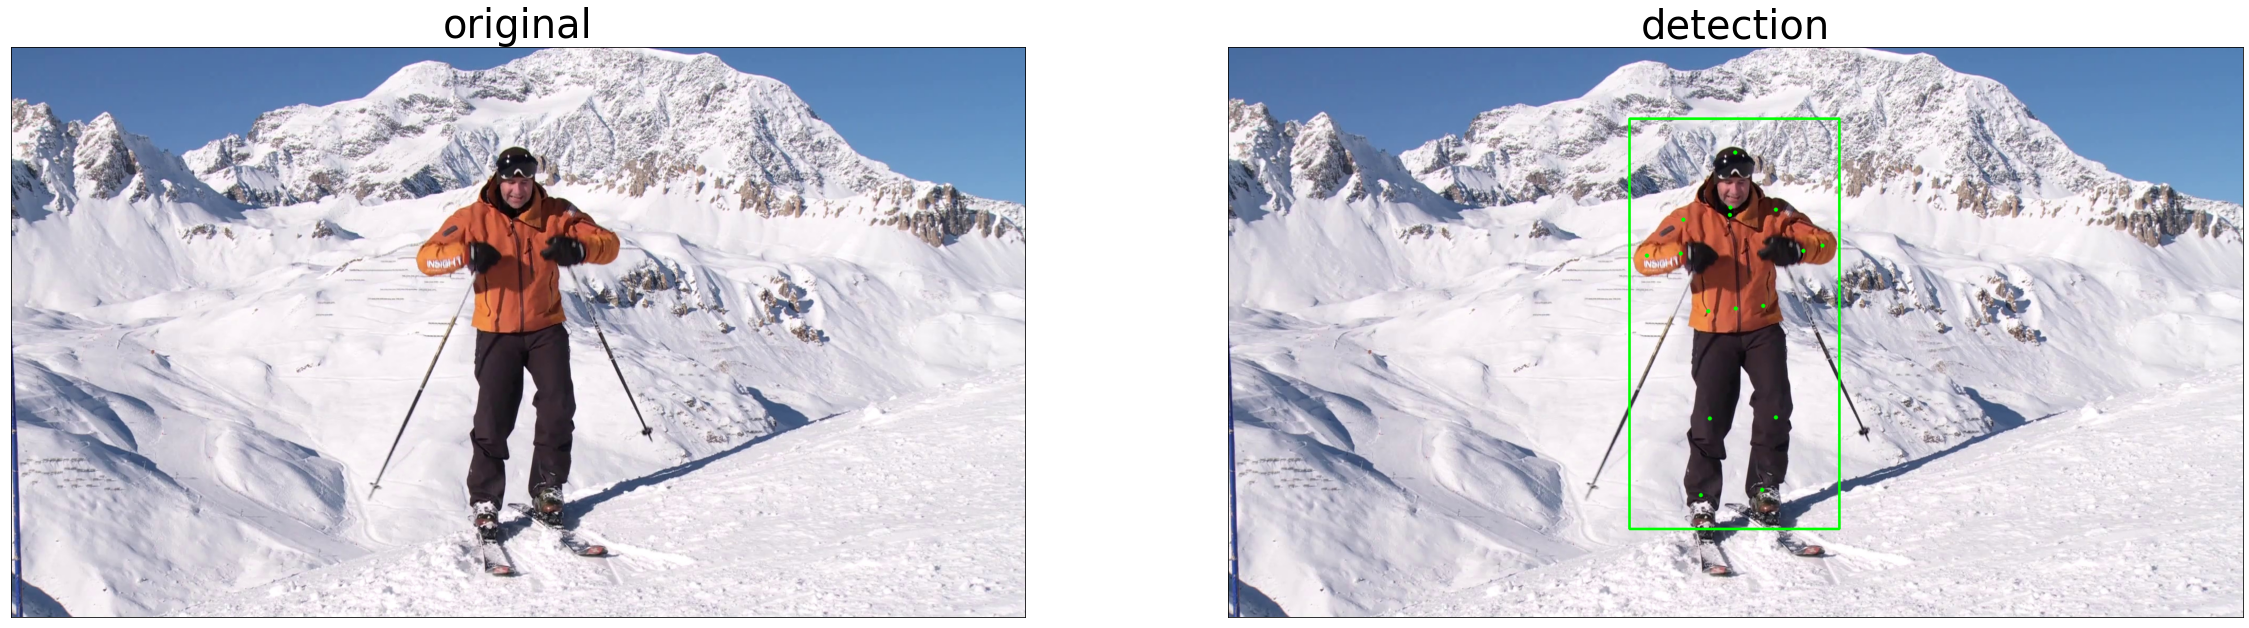

In [ ]:
with open('./data/annotations/train.json') as f:
  data = json.load(f)

# file name, id
file_name, id = ('079991609.jpg', 884)

# keypoint, bbox 추출
annotation_list = []
for key in data['annotations']:
  if key['image_id'] == id:
    annotation_list.append(key)

# original, detection 이미지 나누기
img = cv2.imread(f'./data/images/{file_name}', cv2.IMREAD_COLOR)
img2 = img.copy()

# annotation, bbox 시각화
## keypoints 가 [x,y,v,...] 순서여서 v를 제외한 x,y만 추출

for annotions in  annotation_list:
  x = list(map(int,annotions['keypoints'][::3]))
  y = list(map(int,annotions['keypoints'][1::3]))

  # keypoints 시각화
  for ax, ay in zip(x,y):
    img2 = cv2.circle(img2, (ax,ay), 4, (0,255,0),-1)

  # bbox 시각화
  bbox = annotions['bbox']
  img2 = cv2.rectangle(img2, (int(bbox[0]), int(bbox[1])) , (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])), (0,255,0), 3)


plt.figure(figsize=(40,100))

plt.subplot(1,2,1)
plt.imshow(img[:,:,::-1])
plt.title('original',size=40)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(img2[:,:,::-1])
plt.title('detection',size=40)
plt.xticks([])
plt.yticks([])
plt.show()

&nbsp;

## CUSTOM dataset 만들기

1. `mmpose/configs/_base_/datasets/custom.py` 작성
2. `DATASETS.register` 에 `MyCustomDataset` 등록

### custom.py 작성

- keypoint_info : 각 키포인트에 대한 정보를 포함합니다.
  - name: 키포인트 이름. 키포인트 이름은 고유해야 합니다.
  - id: 키포인트 ID입니다.
  - color: ([B, G, R]) 키포인트 시각화에 사용됩니다.
  - type: 'upper' 또는 'lower'는 이미지 증분에 사용됩니다.
  - swap: '스왑 쌍'('플립 쌍'이라고도 함)을 나타냅니다. 이미지 가로 뒤집기를 적용하면 왼쪽 부분이 오른쪽 부분이 됩니다. 그에 따라 키포인트를 뒤집을 필요가 있습니다.

- skeleton_info : 시각화에 사용되는 키포인트 연결에 대한 정보를 포함합니다
- joint_weights : 다른 키포인트에 다른 손실 가중치를 할당합니다.
- sigmas : OKS 점수를 계산하는 데 사용 ([자세한 내용 참조](https://cocodataset.org/#keypoints-eval))
  - OKS (Object keypoint similarity) : 객체에 대한 key point는 $[x_1, y_1, v_1, ... x_n, y_n, v_n]$ 형태로 존재
    - 이때 $x, y$는 평면상의 위치를 나타내는 좌표
    - $v=0$ : 레이블 되어있지 않음, $v=1$ : 레이블 되어있지만 화면상에서 보이지 않음, $v=2$ : 레이블 되어있고 화면상에서 보임
    - Object Keypoint Similarity (OKS) 공식
    \begin{align}
      OKS = \sum_{i}^{}[exp(\frac{-d^{2}_{i}}{2s^2k^{2}_{i}})\delta(v_i > 0)]/\sum_{i}^{}[\delta(v_i > 0)]
    \end{align}
    - $d_i$ : Ground Truth keypoint와 detection keypoint 사이의 Euclidean distance
    - $v_i$ : Ground Truth의 visibility flag ($v_i$ = 0,1,2)
    - $s$ : 객체 세그먼트 영역의 제곱근
    - $k_i$ : keypoint 마다 존재하는 상수값

In [ ]:
# keypoints 정보 가져오기

with open('./data/annotations/train.json') as f:
  data = json.load(f)

data['categories']

[OrderedDict([('supercategory', 'person'),
              ('id', 1),
              ('name', 'person'),
              ('skeleton',
               [[0, 1],
                [1, 2],
                [2, 6],
                [7, 12],
                [12, 11],
                [11, 10],
                [5, 4],
                [4, 3],
                [3, 6],
                [7, 13],
                [13, 14],
                [14, 15],
                [6, 7],
                [7, 8],
                [8, 9]]),
              ('keypoints',
               ['r_ankle',
                'r_knee',
                'r_hip',
                'l_hip',
                'l_knee',
                'l_ankle',
                'pelvis',
                'throax',
                'upper_neck',
                'head_top',
                'r_wrist',
                'r_elbow',
                'r_shoulder',
                'l_shoulder',
                'l_elbow',
                'l_wrist'])])]

In [ ]:
%%writefile ./configs/_base_/datasets/custom.py
dataset_info = dict(
    dataset_name='MyCustomDataset',
    paper_info=dict(
        author='',
        title='Person',
        container='',
        year='2022',
        homepage='',
    ),
    keypoint_info={
        0:
        dict(name='r_ankle',
             id=0,
             color=[51, 153, 255],
             type='upper',
             swap='l_ankle'),
        1:
        dict(
            name='r_knee',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='l_knee'),
        2:
        dict(
            name='r_hip',
            id=2,
            color=[51, 153, 255],
            type='upper',
            swap='l_hip'),
        3:
        dict(
            name='l_hip',
            id=3,
            color=[51, 153, 255],
            type='upper',
            swap='r_hip'),
        4:
        dict(
            name='l_knee',
            id=4,
            color=[51, 153, 255],
            type='upper',
            swap='r_knee'),
        5:
        dict(
            name='l_ankle',
            id=5,
            color=[0, 255, 0],
            type='upper',
            swap='r_ankle'),
        6:
        dict(
            name='pelvis',
            id=6,
            color=[255, 128, 0],
            type='upper',
            swap=''),
        7:
        dict(
            name='throax',
            id=7,
            color=[0, 255, 0],
            type='upper',
            swap=''),
        8:
        dict(
            name='upper_neck',
            id=8,
            color=[255, 128, 0],
            type='upper',
            swap=''),
        9:
        dict(
            name='head_top',
            id=9,
            color=[0, 255, 0],
            type='upper',
            swap=''),
        10:
        dict(
            name='r_wrist',
            id=10,
            color=[255, 128, 0],
            type='upper',
            swap='l_wrist'),
        11:
        dict(
            name='r_elbow',
            id=11,
            color=[0, 255, 0],
            type='lower',
            swap='l_elbow'),
        12:
        dict(
            name='r_shoulder',
            id=12,
            color=[255, 128, 0],
            type='lower',
            swap='l_shoulder'),
        13:
        dict(
            name='l_shoulder',
            id=13,
            color=[0, 255, 0],
            type='lower',
            swap='r_shoulder'),
        14:
        dict(
            name='l_elbow',
            id=14,
            color=[255, 128, 0],
            type='lower',
            swap='r_elbow'),
        15:
        dict(
            name='l_wrist',
            id=15,
            color=[0, 255, 0],
            type='lower',
            swap='r_wrist')
    },
    skeleton_info={
        0:
        dict(link=('r_ankle', 'r_knee'), id=0, color=[0, 255, 0]),
        1:
        dict(link=('r_knee', 'r_hip'), id=1, color=[0, 255, 0]),
        2:
        dict(link=('r_hip', 'pelvis'), id=2, color=[255, 128, 0]),
        3:
        dict(link=('throax', 'r_shoulder'), id=3, color=[255, 128, 0]),
        4:
        dict(link=('r_shoulder', 'r_elbow'), id=4, color=[51, 153, 255]),
        5:
        dict(link=('r_elbow', 'r_wrist'), id=5, color=[51, 153, 255]),
        6:
        dict(link=('l_ankle', 'l_knee'), id=6, color=[51, 153, 255]),
        7:
        dict(link=('l_knee', 'l_hip'),id=7,color=[51, 153, 255]),
        8:
        dict(link=('l_hip', 'pelvis'), id=8, color=[0, 255, 0]),
        9:
        dict(link=('throax', 'l_shoulder'), id=9, color=[255, 128, 0]),
        10:
        dict(link=('l_shoulder', 'l_elbow'), id=10, color=[0, 255, 0]),
        11:
        dict(link=('l_elbow', 'l_wrist'), id=11, color=[255, 128, 0]),
        12:
        dict(link=('pelvis', 'throax'), id=12, color=[51, 153, 255]),
        13:
        dict(link=('throax', 'upper_neck'), id=13, color=[51, 153, 255]),
        14:
        dict(link=('upper_neck', 'head_top'), id=14, color=[51, 153, 255])
    },
    joint_weights=[
        1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.,
        1.
    ],
    sigmas=[
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05
    ])

Writing ./configs/_base_/datasets/custom.py


In [ ]:
dataset_info = dict(
    dataset_name='MyCustomDataset',
    paper_info=dict(
        author='',
        title='Person',
        container='',
        year='2022',
        homepage='',
    ),
    keypoint_info={
        0:
        dict(name='r_ankle',
             id=0,
             color=[51, 153, 255],
             type='upper',
             swap='l_ankle'),
        1:
        dict(
            name='r_knee',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='l_knee'),
        2:
        dict(
            name='r_hip',
            id=2,
            color=[51, 153, 255],
            type='upper',
            swap='l_hip'),
        3:
        dict(
            name='l_hip',
            id=3,
            color=[51, 153, 255],
            type='upper',
            swap='r_hip'),
        4:
        dict(
            name='l_knee',
            id=4,
            color=[51, 153, 255],
            type='upper',
            swap='r_knee'),
        5:
        dict(
            name='l_ankle',
            id=5,
            color=[0, 255, 0],
            type='upper',
            swap='r_ankle'),
        6:
        dict(
            name='pelvis',
            id=6,
            color=[255, 128, 0],
            type='upper',
            swap=''),
        7:
        dict(
            name='throax',
            id=7,
            color=[0, 255, 0],
            type='upper',
            swap=''),
        8:
        dict(
            name='upper_neck',
            id=8,
            color=[255, 128, 0],
            type='upper',
            swap=''),
        9:
        dict(
            name='head_top',
            id=9,
            color=[0, 255, 0],
            type='upper',
            swap=''),
        10:
        dict(
            name='r_wrist',
            id=10,
            color=[255, 128, 0],
            type='upper',
            swap='l_wrist'),
        11:
        dict(
            name='r_elbow',
            id=11,
            color=[0, 255, 0],
            type='lower',
            swap='l_elbow'),
        12:
        dict(
            name='r_shoulder',
            id=12,
            color=[255, 128, 0],
            type='lower',
            swap='l_shoulder'),
        13:
        dict(
            name='l_shoulder',
            id=13,
            color=[0, 255, 0],
            type='lower',
            swap='r_shoulder'),
        14:
        dict(
            name='l_elbow',
            id=14,
            color=[255, 128, 0],
            type='lower',
            swap='r_elbow'),
        15:
        dict(
            name='l_wrist',
            id=15,
            color=[0, 255, 0],
            type='lower',
            swap='r_wrist')
    },
    skeleton_info={
        0:
        dict(link=('r_ankle', 'r_knee'), id=0, color=[0, 255, 0]),
        1:
        dict(link=('r_knee', 'r_hip'), id=1, color=[0, 255, 0]),
        2:
        dict(link=('r_hip', 'pelvis'), id=2, color=[255, 128, 0]),
        3:
        dict(link=('throax', 'r_shoulder'), id=3, color=[255, 128, 0]),
        4:
        dict(link=('r_shoulder', 'r_elbow'), id=4, color=[51, 153, 255]),
        5:
        dict(link=('r_elbow', 'r_wrist'), id=5, color=[51, 153, 255]),
        6:
        dict(link=('l_ankle', 'l_knee'), id=6, color=[51, 153, 255]),
        7:
        dict(link=('l_knee', 'l_hip'),id=7,color=[51, 153, 255]),
        8:
        dict(link=('l_hip', 'pelvis'), id=8, color=[0, 255, 0]),
        9:
        dict(link=('throax', 'l_shoulder'), id=9, color=[255, 128, 0]),
        10:
        dict(link=('l_shoulder', 'l_elbow'), id=10, color=[0, 255, 0]),
        11:
        dict(link=('l_elbow', 'l_wrist'), id=11, color=[255, 128, 0]),
        12:
        dict(link=('pelvis', 'throax'), id=12, color=[51, 153, 255]),
        13:
        dict(link=('throax', 'upper_neck'), id=13, color=[51, 153, 255]),
        14:
        dict(link=('upper_neck', 'head_top'), id=14, color=[51, 153, 255])
    },
    joint_weights=[
        1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.,
        1.
    ],
    sigmas=[
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05, 0.05, 0.05, 0.05, 0.05,
        0.05
    ])

&nbsp;

### Mydatasets 등록

- 해당 내용의 초안은 'Kpt2dSviewRgbImgTopDownDataset'

- Pose Estimation 방식에서는 Topdown 과 Bottonup 방식이 존재
  - Topdown 방식 : Object를 먼저 detection 하고, bbox 내부에서 pose estimation 을 수행하는 방식
    - 일반적인 정확도가 Bottomup 방식보다 좋음
    - crop 과정이 필요 (detection bbox 내부에서 다시 pose estimation을 수행하기 때문)
    - 객체가 한개가 아닌 다수일경우 속도가 느림 (각 객체를 crop 하고 estimation 하기 때문)
  - Bottomup 방식: pose estimation을 모두 추정하고 상관관계를 분석하여 포즈를 추정하는 방식
    - Topdown 보다 정확도가 다소 떨어짐
    - bbox를 추정하지 않기 때문에 속도가 빠름

In [ ]:
@DATASETS.register_module(name='MyCustomDataset')
class MyCustomDataset(Kpt2dSviewRgbImgTopDownDataset):
    """
    coco 를 기반으로 작성된 dataset에서 필요한 부분만 수정했습니다.
    다른 데이터셋을 사용할때도 변경된 부분만 유의하시면 적용이 가능합니다.

    keypoint indexes:
        0: 'r_ankle',
        1: 'r_knee',
        2: 'r_hip',
        3: 'l_hip',
        4: 'l_knee',
        5: 'l_ankle',
        6: 'pelvis',
        7: 'throax',
        8: 'upper_neck',
        9: 'head_top',
        10: 'r_wrist',
        11: 'r_elbow',
        12: 'r_shoulder',
        13: 'l_shoulder',
        14: 'l_elbow',
        15: 'l_wrist'

    """

    def __init__(self,
                 ann_file,
                 img_prefix,
                 data_cfg,
                 pipeline,
                 dataset_info=None,
                 test_mode=False):

        if dataset_info is None:
            warnings.warn(
                'dataset_info is missing. '
                'Check https://github.com/open-mmlab/mmpose/pull/663 '
                'for details.', DeprecationWarning)
            cfg = Config.fromfile('configs/_base_/datasets/custom.py') # 변경점 기존은 coco.py를 읽어옴
            dataset_info = cfg._cfg_dict['dataset_info']

        super().__init__(
            ann_file,
            img_prefix,
            data_cfg,
            pipeline,
            dataset_info = dataset_info,
            test_mode=test_mode)

        self.use_gt_bbox = data_cfg['use_gt_bbox']
        self.bbox_file = data_cfg['bbox_file']
        self.det_bbox_thr = data_cfg.get('det_bbox_thr', 0.0)
        self.use_nms = data_cfg.get('use_nms', True)
        self.soft_nms = data_cfg['soft_nms']
        self.nms_thr = data_cfg['nms_thr']
        self.oks_thr = data_cfg['oks_thr']
        self.vis_thr = data_cfg['vis_thr']

        self.db = self._get_db()

        print(f'=> num_images: {self.num_images}')
        print(f'=> load {len(self.db)} samples')

    def _get_db(self):
        """Load dataset."""
        if (not self.test_mode) or self.use_gt_bbox:
            # use ground truth bbox
            gt_db = self._load_coco_keypoint_annotations()
        else:
            # use bbox from detection
            gt_db = self._load_coco_person_detection_results()
        return gt_db

    def _load_coco_keypoint_annotations(self):
        """Ground truth bbox and keypoints."""
        gt_db = []
        for img_id in self.img_ids:
            gt_db.extend(self._load_coco_keypoint_annotation_kernel(img_id))
        return gt_db

    def _load_coco_keypoint_annotation_kernel(self, img_id):
        """load annotation from COCOAPI.

        Note:
            bbox:[x1, y1, w, h]

        Args:
            img_id: coco image id

        Returns:
            dict: db entry
        """
        img_ann = self.coco.loadImgs(img_id)[0]
        width = img_ann['width']
        height = img_ann['height']
        num_joints = self.ann_info['num_joints']

        ann_ids = self.coco.getAnnIds(imgIds=img_id, iscrowd=False)
        objs = self.coco.loadAnns(ann_ids)

        # sanitize bboxes
        valid_objs = []
        for obj in objs:
            if 'bbox' not in obj:
                continue
            x, y, w, h = obj['bbox']
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width - 1, x1 + max(0, w))
            y2 = min(height - 1, y1 + max(0, h))
            if ('area' not in obj or obj['area'] > 0) and x2 > x1 and y2 > y1:
                obj['clean_bbox'] = [x1, y1, x2 - x1, y2 - y1]
                valid_objs.append(obj)
        objs = valid_objs

        bbox_id = 0
        rec = []
        for obj in objs:
            if 'keypoints' not in obj:
                continue
            if max(obj['keypoints']) == 0:
                continue
            if 'num_keypoints' in obj and obj['num_keypoints'] == 0:
                continue
            joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d_visible = np.zeros((num_joints, 3), dtype=np.float32)

            keypoints = np.array(obj['keypoints']).reshape(-1, 3)
            joints_3d[:, :2] = keypoints[:, :2]
            joints_3d_visible[:, :2] = np.minimum(1, keypoints[:, 2:3])

            image_file = osp.join(self.img_prefix, self.id2name[img_id])
            rec.append({
                'image_file': image_file,
                'bbox': obj['clean_bbox'][:4],
                'rotation': 0,
                'joints_3d': joints_3d,
                'joints_3d_visible': joints_3d_visible,
                'dataset': self.dataset_name,
                'bbox_score': 1,
                'bbox_id': bbox_id
            })
            bbox_id = bbox_id + 1

        return rec

    def _load_coco_person_detection_results(self):
        """Load coco person detection results."""
        num_joints = self.ann_info['num_joints']
        all_boxes = None
        with open(self.bbox_file, 'r') as f:
            all_boxes = json.load(f)['annotations']  # 변경점 (기존 all_boxes = json.load(f))

        if not all_boxes:
            raise ValueError('=> Load %s fail!' % self.bbox_file)

        print(f'=> Total boxes: {len(all_boxes)}')

        kpt_db = []
        bbox_id = 0
        for det_res in all_boxes:
            if det_res['category_id'] != 1:
                continue

            image_file = osp.join(self.img_prefix,
                                  self.id2name[det_res['image_id']])
            box = det_res['bbox']
            score = 1 # 변경점, det_res['score'] 에러 발생함, 임으로 1로 수정

            if score < self.det_bbox_thr:
                continue

            joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d_visible = np.ones((num_joints, 3), dtype=np.float32)
            kpt_db.append({
                'image_file': image_file,
                'rotation': 0,
                'bbox': box[:4],
                'bbox_score': score,
                'dataset': self.dataset_name,
                'joints_3d': joints_3d,
                'joints_3d_visible': joints_3d_visible,
                'bbox_id': bbox_id
            })
            bbox_id = bbox_id + 1
        print(f'=> Total boxes after filter '
              f'low score@{self.det_bbox_thr}: {bbox_id}')
        return kpt_db

    @deprecated_api_warning(name_dict=dict(outputs='results'))
    def evaluate(self, results, res_folder=None, metric='mAP', **kwargs):
        """Evaluate coco keypoint results. The pose prediction results will be
        saved in ``${res_folder}/result_keypoints.json``.

        Note:
            - batch_size: N
            - num_keypoints: K
            - heatmap height: H
            - heatmap width: W

        Args:
            results (list[dict]): Testing results containing the following
                items:

                - preds (np.ndarray[N,K,3]): The first two dimensions are \
                    coordinates, score is the third dimension of the array.
                - boxes (np.ndarray[N,6]): [center[0], center[1], scale[0], \
                    scale[1],area, score]
                - image_paths (list[str]): For example, ['data/coco/val2017\
                    /000000393226.jpg']
                - heatmap (np.ndarray[N, K, H, W]): model output heatmap
                - bbox_id (list(int)).
            res_folder (str, optional): The folder to save the testing
                results. If not specified, a temp folder will be created.
                Default: None.
            metric (str | list[str]): Metric to be performed. Defaults: 'mAP'.

        Returns:
            dict: Evaluation results for evaluation metric.
        """
        metrics = metric if isinstance(metric, list) else [metric]
        allowed_metrics = ['mAP']
        for metric in metrics:
            if metric not in allowed_metrics:
                raise KeyError(f'metric {metric} is not supported')

        if res_folder is not None:
            tmp_folder = None
            res_file = osp.join(res_folder, 'result_keypoints.json')
        else:
            tmp_folder = tempfile.TemporaryDirectory()
            res_file = osp.join(tmp_folder.name, 'result_keypoints.json')

        kpts = defaultdict(list)

        for result in results:
            preds = result['preds']
            boxes = result['boxes']
            image_paths = result['image_paths']
            bbox_ids = result['bbox_ids']

            batch_size = len(image_paths)
            for i in range(batch_size):
                image_id = self.name2id[image_paths[i][len(self.img_prefix):]]
                kpts[image_id].append({
                    'keypoints': preds[i],
                    'center': boxes[i][0:2],
                    'scale': boxes[i][2:4],
                    'area': boxes[i][4],
                    'score': boxes[i][5],
                    'image_id': image_id,
                    'bbox_id': bbox_ids[i]
                })
        kpts = self._sort_and_unique_bboxes(kpts)

        # rescoring and oks nms
        num_joints = self.ann_info['num_joints']
        vis_thr = self.vis_thr
        oks_thr = self.oks_thr
        valid_kpts = []
        for image_id in kpts.keys():
            img_kpts = kpts[image_id]
            for n_p in img_kpts:
                box_score = n_p['score']
                if kwargs.get('rle_score', False):
                    pose_score = n_p['keypoints'][:, 2]
                    n_p['score'] = float(box_score + np.mean(pose_score) +
                                         np.max(pose_score))
                else:
                    kpt_score = 0
                    valid_num = 0
                    for n_jt in range(0, num_joints):
                        t_s = n_p['keypoints'][n_jt][2]
                        if t_s > vis_thr:
                            kpt_score = kpt_score + t_s
                            valid_num = valid_num + 1
                    if valid_num != 0:
                        kpt_score = kpt_score / valid_num
                    # rescoring
                    n_p['score'] = kpt_score * box_score

            if self.use_nms:
                nms = soft_oks_nms if self.soft_nms else oks_nms
                keep = nms(img_kpts, oks_thr, sigmas=self.sigmas)
                valid_kpts.append([img_kpts[_keep] for _keep in keep])
            else:
                valid_kpts.append(img_kpts)

        self._write_coco_keypoint_results(valid_kpts, res_file)

        # do evaluation only if the ground truth keypoint annotations exist
        if 'annotations' in self.coco.dataset:
            info_str = self._do_python_keypoint_eval(res_file)
            name_value = OrderedDict(info_str)

            if tmp_folder is not None:
                tmp_folder.cleanup()
        else:
            warnings.warn(f'Due to the absence of ground truth keypoint'
                          f'annotations, the quantitative evaluation can not'
                          f'be conducted. The prediction results have been'
                          f'saved at: {osp.abspath(res_file)}')
            name_value = {}

        return name_value

    def _write_coco_keypoint_results(self, keypoints, res_file):
        """Write results into a json file."""
        data_pack = [{
            'cat_id': self._class_to_coco_ind[cls],
            'cls_ind': cls_ind,
            'cls': cls,
            'ann_type': 'keypoints',
            'keypoints': keypoints
        } for cls_ind, cls in enumerate(self.classes)
                     if not cls == '__background__']

        results = self._coco_keypoint_results_one_category_kernel(data_pack[0])

        with open(res_file, 'w') as f:
            json.dump(results, f, sort_keys=True, indent=4)

    def _coco_keypoint_results_one_category_kernel(self, data_pack):
        """Get coco keypoint results."""
        cat_id = data_pack['cat_id']
        keypoints = data_pack['keypoints']
        cat_results = []

        for img_kpts in keypoints:
            if len(img_kpts) == 0:
                continue

            _key_points = np.array(
                [img_kpt['keypoints'] for img_kpt in img_kpts])
            key_points = _key_points.reshape(-1,
                                             self.ann_info['num_joints'] * 3)

            result = [{
                'image_id': img_kpt['image_id'],
                'category_id': cat_id,
                'keypoints': key_point.tolist(),
                'score': float(img_kpt['score']),
                'center': img_kpt['center'].tolist(),
                'scale': img_kpt['scale'].tolist()
            } for img_kpt, key_point in zip(img_kpts, key_points)]

            cat_results.extend(result)

        return cat_results

    def _do_python_keypoint_eval(self, res_file):
        """Keypoint evaluation using COCOAPI."""
        coco_det = self.coco.loadRes(res_file)
        coco_eval = COCOeval(self.coco, coco_det, 'keypoints', self.sigmas)
        coco_eval.params.useSegm = None
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        stats_names = [
            'AP', 'AP .5', 'AP .75', 'AP (M)', 'AP (L)', 'AR', 'AR .5',
            'AR .75', 'AR (M)', 'AR (L)'
        ]

        info_str = list(zip(stats_names, coco_eval.stats))

        return info_str

    def _sort_and_unique_bboxes(self, kpts, key='bbox_id'):
        """sort kpts and remove the repeated ones."""
        for img_id, persons in kpts.items():
            num = len(persons)
            kpts[img_id] = sorted(kpts[img_id], key=lambda x: x[key])
            for i in range(num - 1, 0, -1):
                if kpts[img_id][i][key] == kpts[img_id][i - 1][key]:
                    del kpts[img_id][i]

        return kpts

&nbsp;

## 사용할 모델 (hrnet)

<img src='https://choijhyeok.github.io/images/2023-01-31-HRNet/image-20230131125911018.png'>

- 동일한 resolution이 유지되는 층가 평행하게 down-sampling 되는 구간이 분리되어 존재
  - down-sampling/up-sampling 된 resolution 정보와 원본의 resolution이 변경되지 않은 정보가 합쳐져서 HeatMap Regression을 수행해 keypoints를 찾을때 정확도가 높아짐
    - Direct regression
      - 2차원 이미지 픽셀 값을 입력값으로 이용해 바로 좌표를 추정하는 방식
빠른 학습이 가능, 다수의 사람이 존재할 경우 적용이 어려움
keypoints 위치가 비선형적임으로 적합하게 매핑하기 어렵다는 문제가 존재

    - Heatmap regression
      - 신체 부위중 keypoints가 존재할 만한 위치를 확률적으로 heatmap으로 계산하고 keypoints 위치를 추정
시각적으로 객관적이며 사람이 다수일 경우도 적용 가능
Direct regression보다 일반적으로 성능이 좋음

- 전체적인 구성은 병렬구조로 각각의 Layer에서 정보를 얻는 방식으로 설계
  - 과거의 Pose model은 high -> low -> high 형식으로 down-sampling -> up-sampling 과정으로 진행되었는데 이때 keypoints는 up-sampling 수행시 detection 되면서 up-sampling의 과도한 의존도가 커지는 문제가 존재
  - HRNet 에서는 병렬구조로 다양한 resolution이 fusion되는 방식을 사용함으로써 다양한 scale 정보로 기존의 문제를 해결함

&nbsp;

## Config 수정

- 사용할 py를 가져와서 변경

In [ ]:
load_cfg = Config.fromfile('./configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w32_coco_256x192.py')

# set basic configs
load_cfg.data_root = 'data/' # data 까지의 상위 경로
load_cfg.work_dir = 'work_dirs/out_model' # 결과물 저장 경로
load_cfg.gpu_ids = range(1) # gpu num
load_cfg.seed = 0 # seed

# set log interval
load_cfg.log_config.interval = 1 # 로그 기록 (몇 epoch 마다 기록할것인지)

# set evaluation configs
load_cfg.evaluation.interval = 10 # 평가 기록 (몇 epoch 마다 기록할것인지)
load_cfg.evaluation.metric = 'mAP' # 평가 척도
load_cfg.evaluation.save_best = 'AP' # best model 기준

load_cfg.channel_cfg.num_output_channels = 16 # keypoints 수
load_cfg.channel_cfg.dataset_joints = 16 # keypoints 수
load_cfg.channel_cfg.dataset_channel = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
load_cfg.channel_cfg.inference_channel = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


load_cfg.dataset_info = dataset_info # keypoints 정보 (위에서의 dict)
load_cfg.data_cfg.num_output_channels = load_cfg.channel_cfg.num_output_channels
load_cfg.data_cfg.num_joints = load_cfg.channel_cfg.dataset_joints
load_cfg.data_cfg.dataset_channel = load_cfg.channel_cfg.dataset_channel
load_cfg.data_cfg.inference_channel = load_cfg.channel_cfg.inference_channel
load_cfg.data_cfg.bbox_file = f'{load_cfg.data_root}annotations/train.json' # train json

# model 수정
load_cfg.model.keypoint_head.out_channels=16 # hrnet 에서 출력의 수를 dataset의 keypoints 수로 변경

# set learning rate policy
lr_config = dict(
    policy='cyclic',
    warmup='linear',
    warmup_iters=10,
    warmup_ratio=0.001,
    step=[40, 70])
load_cfg.total_epochs = 100 # 총 epoch 수

# set batch size
load_cfg.data.samples_per_gpu = 16
load_cfg.data.val_dataloader = dict(samples_per_gpu=16)
load_cfg.data.test_dataloader = dict(samples_per_gpu=16)


# train 데이터 설정
load_cfg.data.train.type = 'MyCustomDataset'
load_cfg.data.train.ann_file = f'{load_cfg.data_root}annotations/train.json'
load_cfg.data.train.img_prefix = f'{load_cfg.data_root}images/'

load_cfg.data.train.dataset_info = dataset_info
load_cfg.data.train.data_cfg = load_cfg.data_cfg


# val 데이터 설정
load_cfg.data.val.type = 'MyCustomDataset'
load_cfg.data.val.ann_file = f'{load_cfg.data_root}annotations/val.json'
load_cfg.data.val.img_prefix = f'{load_cfg.data_root}images/'

load_cfg.data.val.dataset_info = dataset_info
load_cfg.data.val.data_cfg = load_cfg.data_cfg
load_cfg.data.val.data_cfg.bbox_file = f'{load_cfg.data_root}annotations/val.json'


# test 데이터 설정
load_cfg.data.test.type = 'MyCustomDataset'
load_cfg.data.test.ann_file = f'{load_cfg.data_root}annotations/val.json'
load_cfg.data.test.img_prefix = f'{load_cfg.data_root}images/'


load_cfg.data.test.dataset_info = dataset_info
load_cfg.data.test.data_cfg = load_cfg.data_cfg
load_cfg.data.test.data_cfg.bbox_file = f'{load_cfg.data_root}annotations/val.json'

&nbsp;

## train

train_model

- model (nn.Module) – Train model
- dataset (Dataset) – Train dataset.
- cfg (dict) – config 내용
- distributed (bool) – 분산훈련 사용여부, Default: False.
- validate (bool) – validation 평가 사용 여부, Default: False.
- timestamp (str | None) – 학습시 Local time 사용 여부. Default: None.
- meta (dict | None) – 추가적인 meta 정보 여부. Default: None


> 기본적인 사용방법 : train_model(model, datasets, load_cfg, validate=True)

In [ ]:
# build dataset (train 데이터셋 빌드)
datasets = [build_dataset(load_cfg.data.train)]

# build model (훈련시킬 모델 빌드)
model = build_posenet(load_cfg.model)

# create work_dir (저장경로 없으면 생성)
mmcv.mkdir_or_exist(load_cfg.work_dir)

# train model (모델 훈련)
train_model(model, datasets, load_cfg, validate=True)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
=> num_images: 800
=> load 1273 samples
load checkpoint from http path: https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth" to /root/.cache/torch/hub/checkpoints/hrnet_w32-36af842e.pth


  0%|          | 0.00/126M [00:00<?, ?B/s]

2023-02-01 01:39:11,641 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
=> Total boxes: 195
=> Total boxes after filter low score@0.0: 195
=> num_images: 100
=> load 195 samples


/usr/local/lib/python3.8/dist-packages/mmcv/runner/hooks/evaluation.py:226: UserWarning: runner.meta is None. Creating an empty one.
  warnings.warn('runner.meta is None. Creating an empty one.')
2023-02-01 01:39:25,031 - mmpose - INFO - Epoch [1][1/80]	lr: 5.000e-07, eta: 21:14:01, time: 9.556, data_time: 2.483, memory: 2494, heatmap_loss: 0.0038, acc_pose: 0.0078, loss: 0.0038
2023-02-01 01:39:25,397 - mmpose - INFO - Epoch [1][2/80]	lr: 1.499e-06, eta: 11:01:19, time: 0.366, data_time: 0.005, memory: 2821, heatmap_loss: 0.0033, acc_pose: 0.0189, loss: 0.0033
2023-02-01 01:39:25,759 - mmpose - INFO - Epoch [1][3/80]	lr: 2.498e-06, eta: 7:36:53, time: 0.362, data_time: 0.003, memory: 2821, heatmap_loss: 0.0033, acc_pose: 0.0078, loss: 0.0033
2023-02-01 01:39:26,140 - mmpose - INFO - Epoch [1][4/80]	lr: 3.497e-06, eta: 5:55:19, time: 0.381, data_time: 0.003, memory: 2821, heatmap_loss: 0.0037, acc_pose: 0.0083, loss: 0.0037
2023-02-01 01:39:26,501 - mmpose - INFO - Epoch [1][5/80]	lr: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 58.6 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.368
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.743
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.253
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.414
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.769
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.400
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 01:44:55,188 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_10.pth.
2023-02-01 01:44:55,190 - mmpose - INFO - Best AP is 0.3679 at 10 epoch.
2023-02-01 01:44:55,191 - mmpose - INFO - Epoch(val) [10][13]	AP: 0.3679, AP .5: 0.7429, AP .75: 0.3427, AP (M): 0.2529, AP (L): 0.3811, AR: 0.4144, AR .5: 0.7692, AR .75: 0.4000, AR (M): 0.3286, AR (L): 0.4210
2023-02-01 01:44:58,268 - mmpose - INFO - Epoch [11][1/80]	lr: 5.000e-04, eta: 0:50:17, time: 3.066, data_time: 2.595, memory: 2821, heatmap_loss: 0.0023, acc_pose: 0.4764, loss: 0.0023
2023-02-01 01:44:58,660 - mmpose - INFO - Epoch [11][2/80]	lr: 5.000e-04, eta: 0:50:17, time: 0.393, data_time: 0.008, memory: 2821, heatmap_loss: 0.0019, acc_pose: 0.5362, loss: 0.0019
2023-02-01 01:44:59,036 - mmpose - INFO - Epoch [11][3/80]	lr: 5.000e-04, eta: 0:50:16, time: 0.376, data_time: 0.005, memory: 2821, heatmap_loss: 0.0018, acc_pose: 0.4931, loss: 0.0018
2023-02-01 01:44:59,411 - mmpose - INFO - Epoch [11][4/80]	lr:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 59.8 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.854
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.465
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.510
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.872
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.523
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 01:50:29,204 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_10.pth was removed
2023-02-01 01:50:30,506 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_20.pth.
2023-02-01 01:50:30,507 - mmpose - INFO - Best AP is 0.4672 at 20 epoch.
2023-02-01 01:50:30,511 - mmpose - INFO - Epoch(val) [20][13]	AP: 0.4672, AP .5: 0.8541, AP .75: 0.4654, AP (M): 0.3492, AP (L): 0.4817, AR: 0.5103, AR .5: 0.8718, AR .75: 0.5231, AR (M): 0.3929, AR (L): 0.5193
2023-02-01 01:50:33,475 - mmpose - INFO - Epoch [21][1/80]	lr: 5.000e-04, eta: 0:44:13, time: 2.954, data_time: 2.502, memory: 2821, heatmap_loss: 0.0017, acc_pose: 0.6246, loss: 0.0017
2023-02-01 01:50:33,860 - mmpose - INFO - Epoch [21][2/80]	lr: 5.000e-04, eta: 0:44:13, time: 0.385, data_time: 0.006, memory: 2821, heatmap_loss: 0.0017, acc_pose: 0.5399, loss: 0.0017
2023-02-01 01:50:34,241 - mmpose - INFO - Epoch [21][3/80]	lr: 5.000e-04, eta: 0:44:12, time: 0.381, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 58.7 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.483
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.808
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.477
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.356
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.529
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.836
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 01:56:05,197 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_20.pth was removed
2023-02-01 01:56:06,666 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_30.pth.
2023-02-01 01:56:06,668 - mmpose - INFO - Best AP is 0.4828 at 30 epoch.
2023-02-01 01:56:06,669 - mmpose - INFO - Epoch(val) [30][13]	AP: 0.4828, AP .5: 0.8077, AP .75: 0.4769, AP (M): 0.3557, AP (L): 0.4967, AR: 0.5287, AR .5: 0.8359, AR .75: 0.5282, AR (M): 0.4071, AR (L): 0.5381
2023-02-01 01:56:09,575 - mmpose - INFO - Epoch [31][1/80]	lr: 5.000e-04, eta: 0:38:35, time: 2.896, data_time: 2.419, memory: 2821, heatmap_loss: 0.0017, acc_pose: 0.6774, loss: 0.0017
2023-02-01 01:56:09,962 - mmpose - INFO - Epoch [31][2/80]	lr: 5.000e-04, eta: 0:38:35, time: 0.387, data_time: 0.009, memory: 2821, heatmap_loss: 0.0017, acc_pose: 0.6681, loss: 0.0017
2023-02-01 01:56:10,343 - mmpose - INFO - Epoch [31][3/80]	lr: 5.000e-04, eta: 0:38:34, time: 0.381, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 58.6 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.843
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.548
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.351
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.543
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.571
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.867
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 02:01:41,307 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_30.pth was removed
2023-02-01 02:01:42,607 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_40.pth.
2023-02-01 02:01:42,608 - mmpose - INFO - Best AP is 0.5260 at 40 epoch.
2023-02-01 02:01:42,611 - mmpose - INFO - Epoch(val) [40][13]	AP: 0.5260, AP .5: 0.8428, AP .75: 0.5476, AP (M): 0.3509, AP (L): 0.5432, AR: 0.5713, AR .5: 0.8667, AR .75: 0.6051, AR (M): 0.3929, AR (L): 0.5851
2023-02-01 02:01:45,625 - mmpose - INFO - Epoch [41][1/80]	lr: 5.000e-04, eta: 0:33:02, time: 3.006, data_time: 2.522, memory: 2821, heatmap_loss: 0.0015, acc_pose: 0.6851, loss: 0.0015
2023-02-01 02:01:46,024 - mmpose - INFO - Epoch [41][2/80]	lr: 5.000e-04, eta: 0:33:01, time: 0.400, data_time: 0.004, memory: 2821, heatmap_loss: 0.0017, acc_pose: 0.6370, loss: 0.0017
2023-02-01 02:01:46,401 - mmpose - INFO - Epoch [41][3/80]	lr: 5.000e-04, eta: 0:33:01, time: 0.377, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 59.0 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.543
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.578
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.412
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.582
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.877
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.626
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 02:07:17,756 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_40.pth was removed
2023-02-01 02:07:19,760 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_50.pth.
2023-02-01 02:07:19,762 - mmpose - INFO - Best AP is 0.5425 at 50 epoch.
2023-02-01 02:07:19,763 - mmpose - INFO - Epoch(val) [50][13]	AP: 0.5425, AP .5: 0.8618, AP .75: 0.5785, AP (M): 0.4124, AP (L): 0.5541, AR: 0.5821, AR .5: 0.8769, AR .75: 0.6256, AR (M): 0.4429, AR (L): 0.5928
2023-02-01 02:07:22,827 - mmpose - INFO - Epoch [51][1/80]	lr: 5.000e-04, eta: 0:27:31, time: 3.053, data_time: 2.572, memory: 2821, heatmap_loss: 0.0015, acc_pose: 0.7235, loss: 0.0015
2023-02-01 02:07:23,218 - mmpose - INFO - Epoch [51][2/80]	lr: 5.000e-04, eta: 0:27:30, time: 0.391, data_time: 0.005, memory: 2821, heatmap_loss: 0.0013, acc_pose: 0.7151, loss: 0.0013
2023-02-01 02:07:23,614 - mmpose - INFO - Epoch [51][3/80]	lr: 5.000e-04, eta: 0:27:30, time: 0.396, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 57.8 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.862
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.601
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.559
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.586
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.872
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.641
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 02:12:54,504 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_50.pth was removed
2023-02-01 02:12:56,065 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_60.pth.
2023-02-01 02:12:56,066 - mmpose - INFO - Best AP is 0.5505 at 60 epoch.
2023-02-01 02:12:56,067 - mmpose - INFO - Epoch(val) [60][13]	AP: 0.5505, AP .5: 0.8622, AP .75: 0.6010, AP (M): 0.4338, AP (L): 0.5595, AR: 0.5856, AR .5: 0.8718, AR .75: 0.6410, AR (M): 0.4929, AR (L): 0.5928
2023-02-01 02:12:59,069 - mmpose - INFO - Epoch [61][1/80]	lr: 5.000e-04, eta: 0:21:59, time: 2.993, data_time: 2.515, memory: 2821, heatmap_loss: 0.0013, acc_pose: 0.7599, loss: 0.0013
2023-02-01 02:12:59,455 - mmpose - INFO - Epoch [61][2/80]	lr: 5.000e-04, eta: 0:21:59, time: 0.386, data_time: 0.005, memory: 2821, heatmap_loss: 0.0014, acc_pose: 0.6524, loss: 0.0014
2023-02-01 02:12:59,828 - mmpose - INFO - Epoch [61][3/80]	lr: 5.000e-04, eta: 0:21:58, time: 0.373, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 57.4 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.560
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.872
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.599
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.887
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 02:18:30,850 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_60.pth was removed
2023-02-01 02:18:32,571 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_70.pth.
2023-02-01 02:18:32,572 - mmpose - INFO - Best AP is 0.5599 at 70 epoch.
2023-02-01 02:18:32,575 - mmpose - INFO - Epoch(val) [70][13]	AP: 0.5599, AP .5: 0.8724, AP .75: 0.5898, AP (M): 0.4323, AP (L): 0.5737, AR: 0.5990, AR .5: 0.8872, AR .75: 0.6359, AR (M): 0.4786, AR (L): 0.6083
2023-02-01 02:18:35,483 - mmpose - INFO - Epoch [71][1/80]	lr: 5.000e-04, eta: 0:16:29, time: 2.896, data_time: 2.432, memory: 2821, heatmap_loss: 0.0010, acc_pose: 0.8447, loss: 0.0010
2023-02-01 02:18:35,885 - mmpose - INFO - Epoch [71][2/80]	lr: 5.000e-04, eta: 0:16:28, time: 0.403, data_time: 0.005, memory: 2821, heatmap_loss: 0.0012, acc_pose: 0.7841, loss: 0.0012
2023-02-01 02:18:36,270 - mmpose - INFO - Epoch [71][3/80]	lr: 5.000e-04, eta: 0:16:28, time: 0.385, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 48.8 task/s, elapsed: 4s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.571
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.896
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.460
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.605
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.903
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium 

2023-02-01 02:24:22,933 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_70.pth was removed
2023-02-01 02:24:24,400 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_80.pth.
2023-02-01 02:24:24,417 - mmpose - INFO - Best AP is 0.5713 at 80 epoch.
2023-02-01 02:24:24,421 - mmpose - INFO - Epoch(val) [80][13]	AP: 0.5713, AP .5: 0.8959, AP .75: 0.5961, AP (M): 0.4599, AP (L): 0.5814, AR: 0.6046, AR .5: 0.9026, AR .75: 0.6359, AR (M): 0.5000, AR (L): 0.6127
2023-02-01 02:24:27,518 - mmpose - INFO - Epoch [81][1/80]	lr: 5.000e-04, eta: 0:11:02, time: 3.084, data_time: 2.603, memory: 2821, heatmap_loss: 0.0013, acc_pose: 0.7871, loss: 0.0013
2023-02-01 02:24:27,907 - mmpose - INFO - Epoch [81][2/80]	lr: 5.000e-04, eta: 0:11:02, time: 0.389, data_time: 0.005, memory: 2821, heatmap_loss: 0.0014, acc_pose: 0.7036, loss: 0.0014
2023-02-01 02:24:28,340 - mmpose - INFO - Epoch [81][3/80]	lr: 5.000e-04, eta: 0:11:02, time: 0.433, data_ti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 56.9 task/s, elapsed: 3s, ETA:     0s

2023-02-01 02:30:13,915 - mmpose - INFO - Epoch(val) [90][13]	AP: 0.5664, AP .5: 0.8909, AP .75: 0.6072, AP (M): 0.4232, AP (L): 0.5817, AR: 0.6056, AR .5: 0.9026, AR .75: 0.6462, AR (M): 0.4786, AR (L): 0.6155


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.566
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.607
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.582
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.606
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.903
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= larg

2023-02-01 02:30:16,897 - mmpose - INFO - Epoch [91][1/80]	lr: 5.000e-04, eta: 0:05:32, time: 2.974, data_time: 2.501, memory: 2821, heatmap_loss: 0.0009, acc_pose: 0.8436, loss: 0.0009
2023-02-01 02:30:17,286 - mmpose - INFO - Epoch [91][2/80]	lr: 5.000e-04, eta: 0:05:32, time: 0.389, data_time: 0.005, memory: 2821, heatmap_loss: 0.0011, acc_pose: 0.7152, loss: 0.0011
2023-02-01 02:30:17,675 - mmpose - INFO - Epoch [91][3/80]	lr: 5.000e-04, eta: 0:05:31, time: 0.390, data_time: 0.004, memory: 2821, heatmap_loss: 0.0012, acc_pose: 0.7358, loss: 0.0012
2023-02-01 02:30:18,058 - mmpose - INFO - Epoch [91][4/80]	lr: 5.000e-04, eta: 0:05:31, time: 0.383, data_time: 0.004, memory: 2821, heatmap_loss: 0.0012, acc_pose: 0.7914, loss: 0.0012
2023-02-01 02:30:18,435 - mmpose - INFO - Epoch [91][5/80]	lr: 5.000e-04, eta: 0:05:30, time: 0.377, data_time: 0.003, memory: 2821, heatmap_loss: 0.0015, acc_pose: 0.6613, loss: 0.0015
2023-02-01 02:30:18,816 - mmpose - INFO - Epoch [91][6/80]	lr: 5.000e-

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 195/195, 57.2 task/s, elapsed: 3s, ETA:     0sLoading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *keypoints*


2023-02-01 02:35:49,426 - mmpose - INFO - The previous best checkpoint /content/mmpose/work_dirs/out_model/best_AP_epoch_80.pth was removed


DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.583
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.901
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.468
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] =  0.619
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] =  0.913
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] =  0.651
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] =  0.507
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] =  0.628


2023-02-01 02:35:51,086 - mmpose - INFO - Now best checkpoint is saved as best_AP_epoch_100.pth.
2023-02-01 02:35:51,088 - mmpose - INFO - Best AP is 0.5828 at 100 epoch.
2023-02-01 02:35:51,090 - mmpose - INFO - Epoch(val) [100][13]	AP: 0.5828, AP .5: 0.9008, AP .75: 0.6169, AP (M): 0.4676, AP (L): 0.5956, AR: 0.6190, AR .5: 0.9128, AR .75: 0.6513, AR (M): 0.5071, AR (L): 0.6276


&nbsp;

## 결과 시각화

- 사전에 학습시킨 모델을 통해서 결과 추론

load checkpoint from local path: pre_model/best_AP_epoch_90.pth
load checkpoint from local path: pre_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


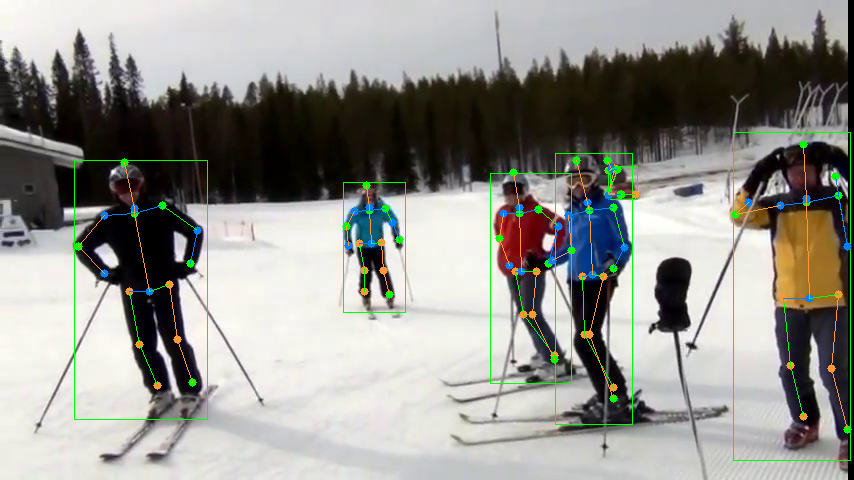

In [ ]:
pose_checkpoint = 'pre_model/best_AP_epoch_90.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'pre_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'


# initialize pose model
pose_model = init_pose_model(load_cfg, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

img = './data/images/001839068.jpg'

# inference detection
mmdet_results = inference_detector(det_model, img)

# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)

# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    img,
    person_results,
    bbox_thr=0.3,
    format='xyxy',
    dataset='MyCustomDataset')

# show pose estimation results
vis_result = vis_pose_result(
    pose_model,
    img,
    pose_results,
    kpt_score_thr=0.,
    dataset='MyCustomDataset',
    show=False)

cv2_imshow(vis_result)

&nbsp;

# Gradio

- Gradio는 머신러닝 모델을 웹 앱 형태로 빌드하고 배포할 수 있도록 돕는 파이썬 라이브러리
  - Gradio를 사용하면 웹 기반 인터페이스를 쉽게 구현할수 있음
- 모델 검증 및 다양한 입력값으로 모델 테스트 수행 가능
- 데모 구현 및 배포가 쉬움
- [Gradio 공식 사이트](https://www.gradio.app/)

In [ ]:
# random_example_image 선택
ran_image = glob('./data/images/*.jpg')
random_image = random.sample(ran_image, k=10) # 10장 random 선택 (비복원)


def pose_predict(img):
  pose_checkpoint = 'pre_model/best_AP_epoch_90.pth' # 사전에 학습시킨 model
  det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py' # faster_rcnn 모델 cfg
  det_checkpoint = 'pre_model/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' # mmpose에서 제공하는 faster_rcnn 모델 (topdown 방식 사용시 object 찾고 crop하기 위한 용도로 사용)

  # initialize pose model
  pose_model = init_pose_model(load_cfg, pose_checkpoint)
  # initialize detector
  det_model = init_detector(det_config, det_checkpoint)

  # inference detection (bbox 추정)
  mmdet_results = inference_detector(det_model, img)

  # extract person (COCO_ID=1) bounding boxes from the detection results (실제 값이 있는 bbox만 선택)
  person_results = process_mmdet_results(mmdet_results, cat_id=1)

  # pose_results (list) : 리스트 안에 dict가 있는 형태, key 목록으로는 'bbox', 'keypoints' 존재
  pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    img,
    person_results,
    bbox_thr=0.3,
    format='xyxy',
    dataset='MyCustomDataset')

  # 추정된 결과 시각화 해주는 함수 show=True 설정시 시각화
  vis_result = vis_pose_result(
      pose_model,
      img,
      pose_results,
      kpt_score_thr=0.,
      dataset='MyCustomDataset',
      show=False)

  return vis_result


# gradio 실행
gr.Interface(fn=pose_predict, inputs="image", outputs="image", examples= random_image, describe='MMPose를 활용한 Pose Estimation DEMO').launch()

/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:43: UserWarning: You have unused kwarg parameters in Interface, please remove them: {'describe': 'MMPose를 활용한 Pose Estimation DEMO'}
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

&nbsp;

## Keypoints 주요 사항

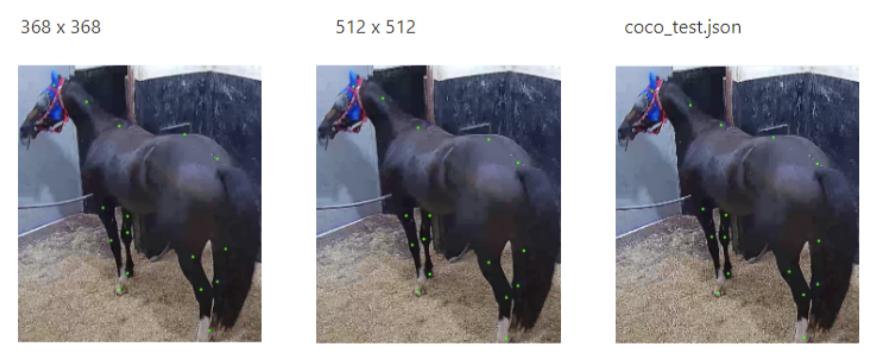